In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Parameters and Configurations

In [3]:
path = "Data"  # Folder containing class subfolders
labelFile = 'labels.csv'  # File containing class labels
batch_size_val = 50  # Number of images processed together in training
steps_per_epoch_val = 2000  # Steps per epoch during training
epochs_val = 15  # Number of training epochs
imageDimensions = (32, 32, 3)  # Image dimensions for model input
testRatio = 0.2  # Ratio of data used for testing
validationRatio = 0.2  # Ratio of remaining data used for validation

## Data Preprocessing

In [5]:
# Load images and labels
def load_data():
    count = 0
    images = []
    classNo = []
    myList = os.listdir(path)
    print("Total Classes Detected:",len(myList))
    noOfClasses=len(myList)
    print("Importing Classes.....")
    for x in range (0,len(myList)):
        myPicList = os.listdir(path+"/"+str(count))
        for y in myPicList:
            curImg = cv2.imread(path+"/"+str(count)+"/"+y)
            images.append(curImg)
            classNo.append(count)
        print(count, end =" ")
        count +=1
    print(" ")
    
    images = np.array(images)
    classNo = np.array(classNo)
    return images, classNo, noOfClasses

images, classNo, noOfClasses = load_data()

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [6]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [7]:
# TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimensions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimensions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimensions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [8]:
# READ CSV FILE
data=pd.read_csv(labelFile)
print("data shape ",data.shape)

data shape  (43, 2)


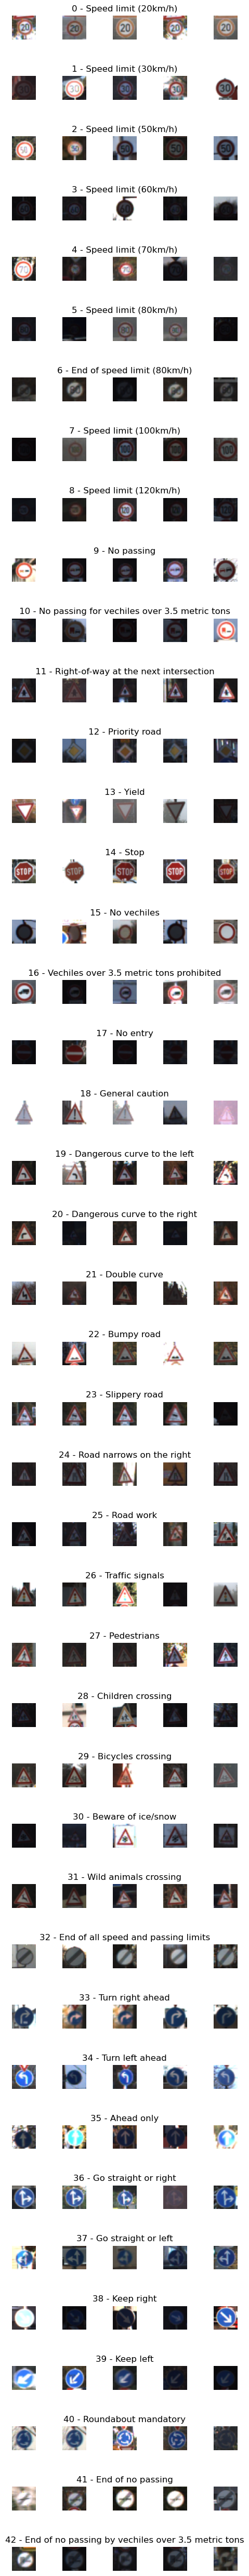

In [9]:
# DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES

# Initialize variables
num_of_samples = []  # List to store the number of samples for each class
cols = 5  # Number of columns in the subplot grid
num_classes = noOfClasses  # Total number of classes

# Create a figure with subplots arranged in a grid of (num_classes x cols)
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()  # Adjust layout for better visualization

# Loop through columns
for i in range(cols):
    # Loop through rows (each class)
    for j, row in data.iterrows():
        # Select images corresponding to the current class
        x_selected = X_train[y_train == j]
        
        # Display a random image from the selected class
        axs[j][i].imshow(
            x_selected[random.randint(0, len(x_selected) - 1), :, :], 
            cmap=plt.get_cmap("gray")
        )
        axs[j][i].axis("off")  # Hide axes for better visualization
        
        # Add title with class index and name for the middle column
        if i == 2:
            axs[j][i].set_title(f"{j} - {row['Name']}")
            
            # Store the number of samples for the current class
            num_of_samples.append(len(x_selected))

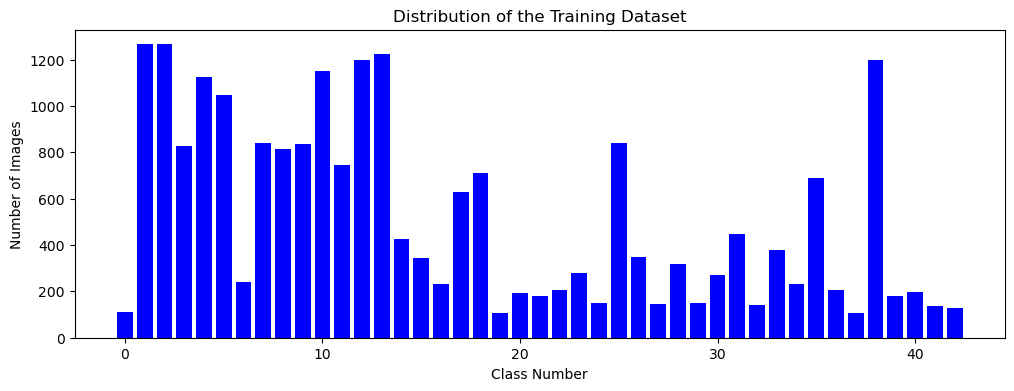

In [10]:
# DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY

# Create a new figure for the bar chart
plt.figure(figsize=(12, 4))  # Set figure size

# Plot a bar chart to visualize the distribution of images per class
plt.bar(range(0, num_classes), num_of_samples, color='blue')

# Add title and labels
plt.title("Distribution of the Training Dataset")  # Title of the plot
plt.xlabel("Class Number")  # X-axis label (class index)
plt.ylabel("Number of Images")  # Y-axis label (number of images per class)

# Show the plot
plt.show()

## Preprocessing the image

In [12]:
# Function to convert an image to grayscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Function to apply histogram equalization for better contrast
def equalize(img):
    return cv2.equalizeHist(img)

# Preprocessing function: Grayscale conversion, equalization, and normalization
def preprocessing(img):
    img = grayscale(img)     # Convert to grayscale
    img = equalize(img)      # Standardize lighting conditions
    img = img / 255.0        # Normalize pixel values (0 to 1)
    return img

# Apply preprocessing to all images in the dataset
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

# Display a random preprocessed image to verify results
cv2.imshow("Grayscale Image", X_train[random.randint(0, len(X_train) - 1)])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
# Reshape the dataset to add a depth of 1 (for grayscale images)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

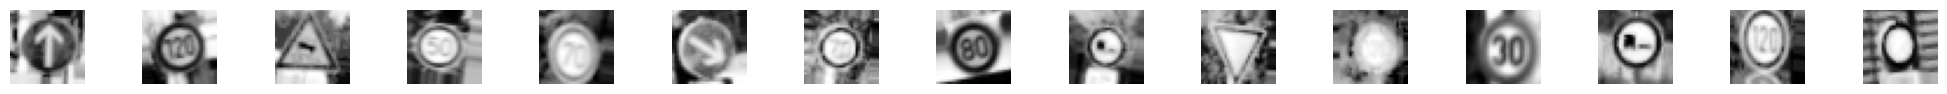

In [14]:
# Augmentation of images to make the model more robust and generalizable
dataGen = ImageDataGenerator(
    width_shift_range=0.1,   # Shift width by up to 10% of the image size
    height_shift_range=0.1,  # Shift height by up to 10% of the image size
    zoom_range=0.2,          # Random zoom within 80% to 120% range
    shear_range=0.1,         # Shear transformation (distortion)
    rotation_range=10        # Random rotation up to ±10 degrees
)

# Fit the generator to the training data
dataGen.fit(X_train)

# Generate augmented images in batches (batch_size = number of images per batch)
batches = dataGen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)  # Retrieve one batch of augmented images

# Display a sample of 15 augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimensions[0], imageDimensions[1]), cmap="gray")
    axs[i].axis('off')

plt.show()

# Convert labels to one-hot encoding for categorical classification
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

## Model Definition

In [16]:
# Define the Convolutional Neural Network model
def myModel():
    no_Of_Filters = 60           # Number of filters in the first two Conv2D layers
    size_of_Filter = (5, 5)      # Kernel size for feature extraction
    size_of_Filter2 = (3, 3)     # Smaller kernel size for deeper layers
    size_of_pool = (2, 2)        # Pooling size to reduce spatial dimensions
    no_Of_Nodes = 500            # Number of neurons in the dense hidden layer

    model = Sequential()

    # First convolutional block
    model.add(Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimensions[0], imageDimensions[1], 1), activation='relu'))
    model.add(Conv2D(no_Of_Filters, size_of_Filter, activation='relu'))
    model.add(MaxPooling2D(pool_size=size_of_pool))  # Downsamples feature maps to prevent overfitting

    # Second convolutional block
    model.add(Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu'))
    model.add(Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu'))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))  # Randomly drops 50% of neurons to reduce overfitting

    # Fully connected layers
    model.add(Flatten())  # Flattens feature maps into a 1D vector
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))  # Further dropout to enhance generalization
    model.add(Dense(noOfClasses, activation='softmax'))  # Output layer for classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [17]:
# Initialize the CNN model
model = myModel()

# Print the model architecture summary
print(model.summary())

# Train the model using the augmented dataset
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val),  # Data generator for real-time augmentation
    steps_per_epoch=steps_per_epoch_val,  # Number of batches per epoch
    epochs=epochs_val,  # Total training epochs
    validation_data=(X_validation, y_validation),  # Validation dataset
    shuffle=True  # Shuffles training data at each epoch to improve generalization
)

C:\Users\thaku\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15


C:\Users\thaku\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 446/2000 ━━━━━━━━━━━━━━━━━━━━ 3:56 152ms/step - accuracy: 0.1515 - loss: 3.1555

C:\Users\thaku\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 78s 37ms/step - accuracy: 0.2600 - loss: 2.6888 - val_accuracy: 0.7252 - val_loss: 0.9498
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.5956 - loss: 1.3187 - val_accuracy: 0.8666 - val_loss: 0.4290
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.7264 - loss: 0.8889 - val_accuracy: 0.9492 - val_loss: 0.1982
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.7869 - loss: 0.6864 - val_accuracy: 0.9623 - val_loss: 0.1492
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.8191 - loss: 0.5798 - val_accuracy: 0.9741 - val_loss: 0.1033
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.8440 - loss: 0.4940 - val_accuracy: 0.9662 - val_loss: 0.1141
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.8572 - loss: 0.4552 - val_accuracy: 0.9736 - val_loss: 0.0816
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.8743 - loss: 0.39

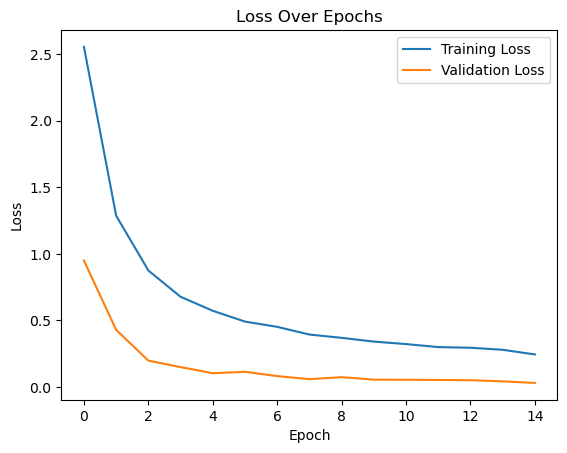

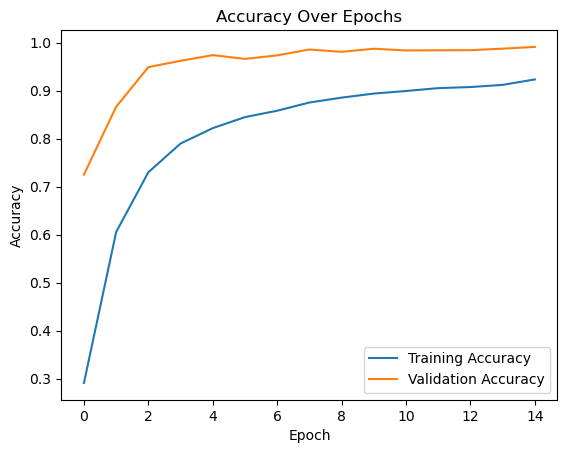

Test Loss: 0.03213264048099518
Test Accuracy: 0.9893678426742554


In [18]:
# Plot training and validation loss over epochs
plt.figure(1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training and validation accuracy over epochs
plt.figure(2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the plots
plt.show()

# Evaluate the trained model on the test dataset
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

In [19]:
# Save the trained model as a pickle object
pickle_out = open("model_trained.p", "wb")  # Open a file for writing bytes
pickle.dump(model, pickle_out)  # Dump the trained model into the file
pickle_out.close()  # Close the file after saving the model

# Wait for a key press to close any open OpenCV windows (if needed)
cv2.waitKey(0)

-1